In [1]:
# dataframe management
import pandas as pd             

# numerical computation
import numpy as np

import re

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   


# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

from bokeh.layouts import gridplot
from bokeh.plotting import figure

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
output_notebook()

from datetime import datetime, timedelta, date
from scipy.stats import skew
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.datasets import load_boston

import statsmodels.api as sm


Loading BokehJS ...

# Functions definitions

In [2]:
def toDate(x):
    parts = [int(el) for el in x.split("/")]
    return date(parts[2], parts[1], parts[0])

def r2_cv(model, sales_train, y, random_state=12345678):
    r2= cross_val_score(model, sales_train, y, scoring="r2", cv =KFold(10, shuffle=True, random_state=random_state)) 
    return(r2)

def rmse_cv(model, sales_train, y, random_state=12345678):
    rmse= np.sqrt(-cross_val_score(model, sales_train, y, scoring="neg_mean_squared_error", cv =KFold(10, shuffle=True, random_state=random_state)))
    return(rmse)

def RegionError(region, data):
    d = data[data[region] == 1][["StoreID","Month","NumberOfSales","NumberOfPredictedSales"]].groupby(["StoreID","Month"]).agg("sum")
    res = abs(d["NumberOfSales"]-d["NumberOfPredictedSales"]).agg("sum")
    return res / d["NumberOfSales"].agg("sum")

def q(col, quant, f):
    t = sales[col].quantile(quant)
    print(f'col {col} at {quant}-th quantile => {t}')
    sales.loc[f(sales[col], t), col] = t
    
def getFilterRegion(cluster, data):
    filterRegion = data[cluster[0]] == 1
    for region in cluster[1:]:
        filterRegion = ((filterRegion) | (data[region]==1))
    return filterRegion

def getColsMatching(data, oldCol):
    return [col for col in data.columns if re.match(r"("+oldCol+"_)(\d)", col)]

def dedummify(data, oldCol):
    return data[getColsMatching(data,oldCol)].idxmax(axis=1).apply(lambda x : x.split("_")[-1])

def firstStepGetModelTrained(cluster, train):
    
    #Get only the data for the required cluster in train and test set
    train_region_label= train.loc[getFilterRegion(cluster,train)]
    print(cluster)
    
    #removing the region columns in order to force the tree alghoritm to do not split for regions
    cols_not_for_step1 = ['Region_PopulationK','Region_AreaKM2','Region_GDP',*cluster]
    train_region_columns = train_region_label[cols_not_for_step1]
    train_region_label=train_region_label.drop(columns=cols_not_for_step1)
    
    train_x_region_label_step1 = train_region_label.drop(columns=['NumberOfSales','NumberOfCustomers'])
    train_y_region_label_step1 = pd.DataFrame(data = train_region_label['NumberOfCustomers'])
    
    #First model predicting NumberOfCustomers
    model_simple = RandomForestRegressor()
    model_simple = model_simple.fit(train_x_region_label_step1, train_y_region_label_step1)
    
    return (model_simple, cols_not_for_step1)

def secondStepGetModelTrained(train):
    train_x_step2 = train.drop(columns=['NumberOfSales'])
    train_y_step2 = pd.DataFrame(data = train['NumberOfSales']) 
    cols_for_step2 = [*getColsMatching(train,"Month"), *getColsMatching(train,"Region"),'NumberOfCustomers','Region_AreaKM2','HasPromotions','IsHoliday','Region_GDP', "StoreID"]
    train_x_step2 = train_x_step2[cols_for_step2]
    
    #STEP2
    model_simple_step2 = RandomForestRegressor()
    model_simple_step2 = model_simple_step2.fit(train_x_step2, train_y_step2)
    
    return (model_simple_step2, cols_for_step2)

def getModelsTrained(clusters, train_1, train):
    models = {}
    for cluster in clusters:
        models[str(cluster)] = firstStepGetModelTrained(cluster, train_1)
    # Prepare data for step2
    return models, secondStepGetModelTrained(train)


# Read input data

In [3]:
# Reading the data
sales =pd.read_csv('train.csv')
sales = sales.append(pd.read_csv('test.csv'))
# Removing tuples where stores are closed
sales = sales[sales['IsOpen'] == 1]
# Converting to category columns that are labels
for el in ["StoreID", "Region"]:
    sales[el] = sales[el].astype("category")

In [4]:
nulls = sales.isnull().sum()
sorted([(x,y) for (x,y) in zip(nulls.index, nulls) if y>0], key=lambda x: x[1], reverse=True)

[('Max_Gust_SpeedKm_h', 370184),
 ('Events', 117386),
 ('CloudCover', 41545),
 ('NumberOfCustomers', 37586),
 ('NumberOfSales', 37586),
 ('Max_VisibilityKm', 11408),
 ('Mean_VisibilityKm', 11408),
 ('Min_VisibilitykM', 11408)]

We see that Max_Gust_SpeedKm_h has 409947 missing values. We decided not to impute it.

Let's start with imputation of "Events"

In [5]:
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_missing.describe()

,CloudCover,HasPromotions,IsHoliday,IsOpen,Max_Dew_PointC,Max_Gust_SpeedKm_h,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_VisibilityKm,...,Min_TemperatureC,Min_VisibilitykM,NearestCompetitor,NumberOfCustomers,NumberOfSales,Precipitationmm,Region_AreaKM2,Region_GDP,Region_PopulationK,WindDirDegrees
count,88353.000000,117386.000000,117386.000000,117386.0,117386.000000,16279.000000,117386.000000,117386.000000,117386.000000,106405.000000,...,117386.000000,106405.000000,117386.000000,103661.000000,103661.000000,117386.000000,117386.000000,117386.000000,117386.000000,117386.000000
mean,4.972587,0.447864,0.000954,1.0,7.170906,41.117329,88.402288,1021.152931,16.380778,23.647357,...,5.941893,10.648541,8573.609102,314.641910,4893.577276,0.003462,11738.380122,13757.148229,3507.508681,138.522490
std,2.231730,0.497277,0.030874,0.0,6.222045,10.304880,9.065070,7.073287,8.454013,9.066879,...,6.504197,6.116777,12144.683666,159.283348,2238.517426,0.082444,8525.873473,2742.219077,2686.068085,105.897769
min,0.000000,0.000000,0.000000,1.0,-11.000000,23.000000,44.000000,995.000000,-9.000000,2.000000,...,-12.000000,0.000000,47.000000,0.000000,0.000000,0.000000,344.000000,9893.000000,816.000000,-1.000000
25%,3.000000,0.000000,0.000000,1.0,2.000000,34.000000,82.000000,1016.000000,10.000000,11.000000,...,1.000000,8.000000,1116.000000,215.000000,3375.000000,0.000000,7215.000000,11849.000000,1293.000000,47.000000
50%,5.000000,0.000000,0.000000,1.0,7.000000,40.000000,88.000000,1021.000000,17.000000,31.000000,...,6.000000,10.000000,3614.000000,280.000000,4461.000000,0.000000,9337.000000,13155.000000,1892.000000,129.000000
75%,7.000000,1.000000,0.000000,1.0,12.000000,47.000000,94.000000,1026.000000,23.000000,31.000000,...,11.000000,10.000000,10593.000000,372.000000,5918.000000,0.000000,15566.000000,15931.000000,5727.000000,221.000000
max,8.000000,1.000000,1.000000,1.0,23.000000,77.000000,100.000000,1042.000000,37.000000,31.000000,...,23.000000,31.000000,85070.000000,2206.000000,26641.000000,4.060000,32221.000000,23931.000000,8146.000000,360.000000


In [6]:
sales['Events'].value_counts()

Rain                           183464
Fog                             61325
Fog-Rain                        43791
Rain-Thunderstorm               18794
Rain-Snow                       16137
Snow                            12789
Fog-Rain-Thunderstorm            6546
Fog-Rain-Snow                    2696
Fog-Snow                         2469
Rain-Hail                        1647
Thunderstorm                     1298
Rain-Snow-Hail                   1133
Rain-Hail-Thunderstorm            310
Rain-Snow-Thunderstorm            307
Fog-Rain-Hail-Thunderstorm        303
Rain-Snow-Hail-Thunderstorm       290
Fog-Rain-Snow-Hail                231
Fog-Snow-Hail                     169
Fog-Rain-Hail                     168
Fog-Thunderstorm                  157
Snow-Hail                         134
Name: Events, dtype: int64

By this, we discovered that when Event is null the weather is good, from the fact that Precipitationmm mean is almost 0.
Furthermore, all the labels of Events are related to bad weather, that means that when no precipitation occurs the label is null.
We will impute Event by replacing the missing values with "Not Specified" (later).

Now we impute "CloudCover", making a distinction when it misses along with Events and when it misses on its own.

In [7]:
null_Events = sales['Events'].isnull()
null_CloudCover = sales['CloudCover'].isnull()
cloudcover_missing = sales[(null_Events)]
null_Events = sales['Events'].isnull()
event_missing = sales[null_Events]
event_cc_missing = sales[null_CloudCover & null_Events]

cloudcover_missing.shape, event_missing.shape, event_cc_missing.shape 

((117386, 36), (117386, 36), (29033, 36))

There are 28k tuples where both "Events" and "CloudCover" are missing, that means that the weather should be good.
for the remaining (41k-28k) (i.e. where "Events" is not null!) tuples we impute the CloudCoverage.

In [8]:
event_notmissing_cc_missing = sales[null_CloudCover & ~null_Events]
#computing mean where CloudCover is not null
mean_CC = sales["CloudCover"].mean()
event_notmissing_cc_missing["CloudCover"] = event_notmissing_cc_missing["CloudCover"].fillna(mean_CC)
sales = pd.concat([sales[~null_CloudCover | null_Events], event_notmissing_cc_missing])

Then, we impute the remaining rows with CloudCover missing

In [9]:
null_Events = sales['Events'].isnull()
CloudyButNotEvent = sales[null_Events]
#there are some tuples with no Events but with the attribute CloudCover

In [10]:
null_cloudCover = sales[sales['CloudCover'].isnull()]
mean_cloudCover = sales["CloudCover"].mean()
null_cloudCover["CloudCover"] = null_cloudCover["CloudCover"].fillna(mean_cloudCover)

sales = pd.concat([sales[~sales['CloudCover'].isnull()], null_cloudCover])

Now, we impute min,max,mean_VisibilityKm. 

In [11]:
# checking if are all the same rows where visibility data are missing => yes, they are
sales[["Max_VisibilityKm", "Mean_VisibilityKm", "Min_VisibilitykM"]].count()

Max_VisibilityKm     460136
Mean_VisibilityKm    460136
Min_VisibilitykM     460136
dtype: int64

In [12]:
null_visibility = sales[sales['Max_VisibilityKm'].isnull()]
mean_vis_max = sales["Max_VisibilityKm"].mean()
mean_vis_mean = sales["Mean_VisibilityKm"].mean()
mean_vis_min = sales["Min_VisibilitykM"].mean()

null_visibility["Max_VisibilityKm"] = null_visibility["Max_VisibilityKm"].fillna(mean_vis_max)
null_visibility["Mean_VisibilityKm"] = null_visibility["Mean_VisibilityKm"].fillna(mean_vis_mean)
null_visibility["Min_VisibilitykM"] = null_visibility["Min_VisibilitykM"].fillna(mean_vis_min)

sales = pd.concat([sales[~sales['Max_VisibilityKm'].isnull()], null_visibility])

Finally, we impute "Events".

In [13]:
sales = sales.replace(np.nan,'NotSpecified', regex=True)


# Dealing with outliers

In [14]:
sales.quantile(.99).sort_values(ascending=False).head(20)

NearestCompetitor             59199.0
Region_AreaKM2                32221.0
Region_GDP                    23931.0
Region_PopulationK             8146.0
StoreID                        1741.0
Max_Sea_Level_PressurehPa      1037.0
Mean_Sea_Level_PressurehPa     1034.0
Min_Sea_Level_PressurehPa      1032.0
WindDirDegrees                  354.0
Max_Humidity                    100.0
Mean_Humidity                    99.0
Min_Humidity                     93.0
Max_Wind_SpeedKm_h               50.0
Max_TemperatureC                 32.0
Max_VisibilityKm                 31.0
Mean_Wind_SpeedKm_h              31.0
Mean_VisibilityKm                30.0
Min_VisibilitykM                 29.0
Mean_TemperatureC                24.0
Max_Dew_PointC                   20.0
Name: 0.99, dtype: float64

In [15]:
q("NearestCompetitor", .95, lambda x, y: x > y)
q("Precipitationmm", .95, lambda x, y: x > y)
q("Max_Wind_SpeedKm_h", .95, lambda x,y: x > y)
q("Max_Wind_SpeedKm_h", .03, lambda x,y: x < y)
q("Max_TemperatureC", .95, lambda x,y: x > y)
q("Max_TemperatureC", .03, lambda x,y: x < y)
q("Min_TemperatureC", .95, lambda x,y: x > y)
q("Min_TemperatureC", .03, lambda x,y: x < y)
q("Mean_Dew_PointC", .95, lambda x,y: x > y)
q("Mean_Dew_PointC", .05, lambda x,y: x < y)
q("Mean_Dew_PointC", .95, lambda x,y: x > y)
q("Mean_Dew_PointC", .05, lambda x,y: x < y)
q("Mean_Humidity", .95, lambda x,y: x > y)
q("Mean_Humidity", .03, lambda x,y: x < y)
q("Min_VisibilitykM", .95, lambda x,y: x > y)
q("Min_Humidity", .03, lambda x,y: x < y)
q("Min_Humidity", .95, lambda x,y: x > y)
q("Mean_Wind_SpeedKm_h", .95, lambda x,y: x > y)
q("Mean_TemperatureC", .03, lambda x,y: x < y)
q("Mean_TemperatureC", .95, lambda x,y: x > y)
q("Mean_VisibilityKm", .05, lambda x,y: x < y)
q("Mean_VisibilityKm", .95, lambda x,y: x > y)

col NearestCompetitor at 0.95-th quantile => 31706.399999986403
col Precipitationmm at 0.95-th quantile => 5.08
col Max_Wind_SpeedKm_h at 0.95-th quantile => 39.0
col Max_Wind_SpeedKm_h at 0.03-th quantile => 11.0
col Max_TemperatureC at 0.95-th quantile => 27.0
col Max_TemperatureC at 0.03-th quantile => 1.0
col Min_TemperatureC at 0.95-th quantile => 16.0
col Min_TemperatureC at 0.03-th quantile => -5.0
col Mean_Dew_PointC at 0.95-th quantile => 15.0
col Mean_Dew_PointC at 0.05-th quantile => -3.0
col Mean_Dew_PointC at 0.95-th quantile => 15.0
col Mean_Dew_PointC at 0.05-th quantile => -3.0
col Mean_Humidity at 0.95-th quantile => 94.0
col Mean_Humidity at 0.03-th quantile => 49.0
col Min_VisibilitykM at 0.95-th quantile => 11.0
col Min_Humidity at 0.03-th quantile => 19.0
col Min_Humidity at 0.95-th quantile => 83.0
col Mean_Wind_SpeedKm_h at 0.95-th quantile => 24.0
col Mean_TemperatureC at 0.03-th quantile => -2.0
col Mean_TemperatureC at 0.95-th quantile => 21.0
col Mean_Visibil

# Normalization of Numerical Variables

Text(0.5,1,'')

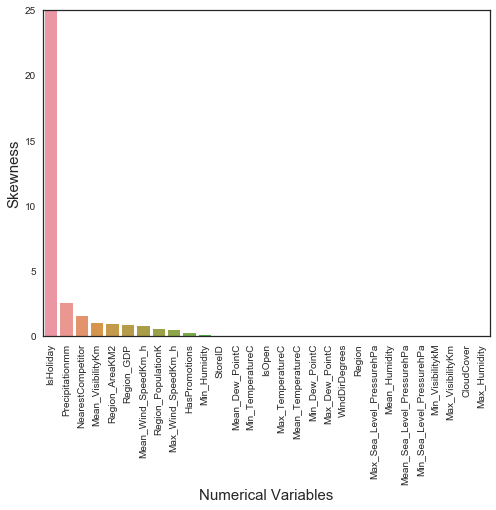

In [16]:
# take the numerical features
numeric_feats = sales.dtypes[sales.dtypes != "object"].index
# compute the skewness but only for non missing variables (we already imputed them but just in case ...)
skewed_feats = sales[numeric_feats].apply(lambda x: skew(x.dropna()))

skewness = pd.DataFrame({"Variable":skewed_feats.index, "Skewness":skewed_feats.data})
# select the variables with a skewness above a certain threshold
skewness = skewness.sort_values('Skewness', ascending=[0])
f, ax = plt.subplots(figsize=(8,6))
plt.xticks(rotation='90')
sns.barplot(x=skewness['Variable'], y=skewness['Skewness'])
plt.ylim(0,25)
plt.xlabel('Numerical Variables', fontsize=15)
plt.ylabel('Skewness', fontsize=15)
plt.title('', fontsize=15)

In [17]:
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.drop(['IsHoliday'])#,'NumberOfCustomers', "NumberOfSales"])
sales[skewed_feats.index] = np.log1p(sales[skewed_feats.index])

# Correlation Analysis and Feature Selection

By analyzing the correlation, we see that the following variables do not add any additional information. 
Max_Dew_PointC, Min_Dew_PointC, Max_Sea_Level_PressurehPa, Mean_Sea_Level_PressurehPa, Max_Gust_SpeedKm_h
Finally, we drop 'NumberOfCustomers' because is not present in the submission dataset.

In [18]:
sales=sales.drop(columns=['Max_Dew_PointC','Min_Dew_PointC','Max_Sea_Level_PressurehPa','Mean_Sea_Level_PressurehPa','Max_Gust_SpeedKm_h'])
sales.shape

(471544, 31)

Drop of the row where IsOpen==0

In [19]:
sales=sales[sales['IsOpen']==1]
sales=sales.drop(columns=['IsOpen'])

### Convert Date to weekday label

In [20]:
sales["Date"] = sales["Date"].apply(toDate)
sales["Day_Of_Week"] = sales["Date"].astype("datetime64").dt.weekday_name

### Convert Date to month label

In [21]:
sales["Month"] = sales["Date"].astype("datetime64").dt.month

### Adding info about avgsales per month ecc.

In [22]:
avgSalesForStoreIDForMonth = sales[sales["NumberOfSales"] != 'NotSpecified']
avgSalesForStoreIDForMonth["NumberOfSales"] = avgSalesForStoreIDForMonth["NumberOfSales"].astype("int")
avgSalesForStoreIDForMonth = avgSalesForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfSales'].mean() 
avgSalesForStoreIDForMonth = avgSalesForStoreIDForMonth.rename(index=str, columns={"NumberOfSales": "AvgSalesForMonth"})

varSalesForStoreIDForMonth = sales[sales["NumberOfSales"] != 'NotSpecified']
varSalesForStoreIDForMonth["NumberOfSales"] = varSalesForStoreIDForMonth["NumberOfSales"].astype("int")
varSalesForStoreIDForMonth = varSalesForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfSales'].var() 
varSalesForStoreIDForMonth = varSalesForStoreIDForMonth.rename(index=str, columns={"NumberOfSales": "VarSalesForMonth"})

avgCustomersForStoreIDForMonth = sales[sales["NumberOfCustomers"] != 'NotSpecified']
avgCustomersForStoreIDForMonth["NumberOfCustomers"] = avgCustomersForStoreIDForMonth["NumberOfCustomers"].astype("int")
avgCustomersForStoreIDForMonth = avgCustomersForStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfCustomers'].mean() 
avgCustomersForStoreIDForMonth = avgCustomersForStoreIDForMonth.rename(index=str, columns={"NumberOfCustomers": "AvgCustomersForMonth"})

varCustomersorStoreIDForMonth = sales[sales["NumberOfSales"] != 'NotSpecified']
varCustomersorStoreIDForMonth["NumberOfCustomers"] = varCustomersorStoreIDForMonth["NumberOfCustomers"].astype("int")
varCustomersorStoreIDForMonth = varCustomersorStoreIDForMonth.groupby(['StoreID','Month'], as_index=False)['NumberOfCustomers'].var() 
varCustomersorStoreIDForMonth = varCustomersorStoreIDForMonth.rename(index=str, columns={"NumberOfCustomers": "VarCustomersForMonth"})

sales = sales.merge(avgSalesForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month']) 
sales = sales.merge(varSalesForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month'])
sales = sales.merge(avgCustomersForStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month']) 
sales = sales.merge(varCustomersorStoreIDForMonth, left_on=['StoreID','Month'], right_on = ['StoreID','Month'])

# Dummify variables

In [23]:
sales = pd.get_dummies(sales, columns=['StoreType','Events','AssortmentType', "Region", "Day_Of_Week","Month"])

# Train and Test Definition
Separating the last 2 months, and use those as a test set and comparing the total of the predicted values.

In [24]:
start_train = date(2018, 3, 1)
train = sales[sales["Date"] - start_train < timedelta(0)]
test = sales[sales["Date"] - start_train > timedelta(days=1)]
train = train.drop(columns=["Date"])
test = test.drop(columns=["Date"])
test = test.drop(columns=["NumberOfCustomers","NumberOfSales"])

In [25]:
train.NumberOfSales = train.NumberOfSales.astype('int')
train.NumberOfCustomers = train.NumberOfCustomers.astype('int')

In [26]:
cols_not_for_step1 = ["NumberOfCustomers","NumberOfSales",'Region_PopulationK','Region_AreaKM2','Region_GDP','Region_0','Region_1','Region_4','Region_5','Region_7','Region_8','Region_10','Region_2','Region_3', 'Region_6', 'Region_9'
]
train_saved_columns = train[cols_not_for_step1]


In [27]:
train_x = train.drop(columns=['NumberOfSales','NumberOfCustomers'])
train_y = pd.DataFrame(data = train['NumberOfCustomers'])
    
#First model predicting NumberOfCustomers
model_simple = RandomForestRegressor()
model_simple = model_simple.fit(train_x, train_y)

Variable: AvgCustomersForMonth Importance: 0.84
Variable: HasPromotions        Importance: 0.04
Variable: Min_Sea_Level_PressurehPa Importance: 0.01
Variable: VarSalesForMonth     Importance: 0.01
Variable: VarCustomersForMonth Importance: 0.01
Variable: Day_Of_Week_Monday   Importance: 0.01
Variable: Day_Of_Week_Saturday Importance: 0.01
Variable: CloudCover           Importance: 0.0
Variable: IsHoliday            Importance: 0.0
Variable: Max_Humidity         Importance: 0.0
Variable: Max_TemperatureC     Importance: 0.0
Variable: Max_VisibilityKm     Importance: 0.0
Variable: Max_Wind_SpeedKm_h   Importance: 0.0
Variable: Mean_Dew_PointC      Importance: 0.0
Variable: Mean_Humidity        Importance: 0.0
Variable: Mean_TemperatureC    Importance: 0.0
Variable: Mean_VisibilityKm    Importance: 0.0
Variable: Mean_Wind_SpeedKm_h  Importance: 0.0
Variable: Min_Humidity         Importance: 0.0
Variable: Min_TemperatureC     Importance: 0.0
Variable: Min_VisibilitykM     Importance: 0.0
V

'# Train the expanded model on only the important features\nmodel_simple = RandomForestRegressor()\nmodel_simple = model_simple.fit(important_train_features, train_y);'

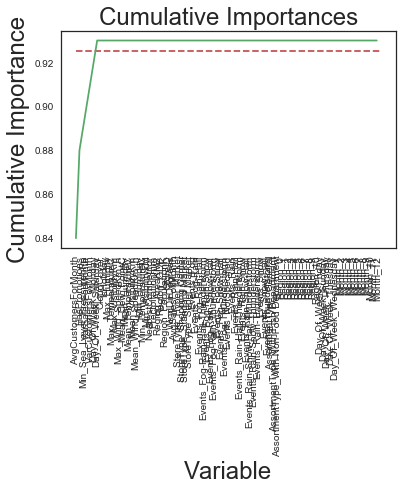

In [28]:
# Get numerical feature importances
importances = list(model_simple.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train_x, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
# list of x locations for plotting
x_values = list(range(len(importances)))
    
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 92,5% of importance retained
plt.hlines(y = 0.925, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');
    
# Find number of features for cumulative importance of 92,5%
# Add 1 because Python is zero-indexed
print('Number of features for 92,5% importance:', np.where(cumulative_importances > 0.925)[0][0] + 1)
    
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:6]]
    
# Find the columns of the most important features
important_indices = [list(train.columns).index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = train_x.values[:, important_indices]
important_test_features = test.values[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)
        
'''# Train the expanded model on only the important features
model_simple = RandomForestRegressor()
model_simple = model_simple.fit(important_train_features, train_y);'''
    

In [29]:
important_train_features = pd.DataFrame(data=important_train_features)
important_test_features = pd.DataFrame(data=important_test_features)

In [30]:
important_train_features[train_saved_columns.columns]=train_saved_columns
important_test_features[train_saved_columns.columns]=train_saved_columns

important_test_features = important_test_features.drop(columns=["NumberOfCustomers","NumberOfSales"])



Clusterization of regions which are similar or with too few samples to be fitted on their own.
Used t-sne to visualize clusters

In [31]:
Region_labels = [['Region_0', 'Region_1', 'Region_4','Region_5','Region_7', 'Region_8', 'Region_10' ], ['Region_2'], ['Region_3'], ['Region_6', 'Region_9']]
# it can be useful to move also region 6 in the first big cluster

In [32]:
'''import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from scipy.spatial.distance import cdist, pdist

import matplotlib
%matplotlib inline

# color palette 
color_palette1 = matplotlib.colors.ListedColormap([plt.cm.Paired.colors[0],plt.cm.Paired.colors[2],plt.cm.Paired.colors[4]], name='DecisionSurfaceColorMap')
color_palette2 = matplotlib.colors.ListedColormap([plt.cm.Paired.colors[1],plt.cm.Paired.colors[3],plt.cm.Paired.colors[5]], name='DataPointsColorMap')'''

"import numpy as np\nimport matplotlib.pyplot as plt\n\nfrom sklearn.cluster import KMeans\nfrom sklearn.datasets import make_blobs\n\nfrom scipy.spatial.distance import cdist, pdist\n\nimport matplotlib\n%matplotlib inline\n\n# color palette \ncolor_palette1 = matplotlib.colors.ListedColormap([plt.cm.Paired.colors[0],plt.cm.Paired.colors[2],plt.cm.Paired.colors[4]], name='DecisionSurfaceColorMap')\ncolor_palette2 = matplotlib.colors.ListedColormap([plt.cm.Paired.colors[1],plt.cm.Paired.colors[3],plt.cm.Paired.colors[5]], name='DataPointsColorMap')"

In [33]:
'''yp = KMeans(n_clusters=3).fit_predict(train)
plt.figure(figsize=(8, 6));
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.scatter(train.values[:,0],train.values[:,80],c=yp,cmap=color_palette1);'''

"yp = KMeans(n_clusters=3).fit_predict(train)\nplt.figure(figsize=(8, 6));\nfont = {'family' : 'sans', 'size'   : 18}\nplt.rc('font', **font)\nplt.scatter(train.values[:,0],train.values[:,80],c=yp,cmap=color_palette1);"

In [34]:
m_step_1, m_step_2 = getModelsTrained(Region_labels, important_train_features, train)

['Region_0', 'Region_1', 'Region_4', 'Region_5', 'Region_7', 'Region_8', 'Region_10']
['Region_2']
['Region_3']
['Region_6', 'Region_9']


In [35]:
important_test_features["NumberOfCustomers"]=0
for cluster in Region_labels:
    cluster_region_only = important_test_features[getFilterRegion(cluster,important_test_features)]
    important_test_features.loc[getFilterRegion(cluster,important_test_features), "NumberOfCustomers"]= m_step_1[str(cluster)][0].predict(cluster_region_only.drop(columns=["NumberOfCustomers",*m_step_1[str(cluster)][1]]))


In [36]:
test.shape

(36092, 86)

In [37]:
test.index = range(36092)

In [38]:
test["NumberOfCustomers"]= important_test_features["NumberOfCustomers"]



In [39]:
test.sort_index(ascending=True)

,CloudCover,HasPromotions,IsHoliday,Max_Humidity,Max_TemperatureC,Max_VisibilityKm,Max_Wind_SpeedKm_h,Mean_Dew_PointC,Mean_Humidity,Mean_TemperatureC,...,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,NumberOfCustomers
0,2.000000,0,0,100,8.0,31.000000,18.0,-1.0,74.0,3.0,...,0,0,0,0,0,0,0,0,0,510.866667
1,4.000000,1,0,87,10.0,26.000000,39.0,1.0,65.0,6.0,...,0,0,0,0,0,0,0,0,0,596.100000
2,4.000000,1,0,87,11.0,14.000000,37.0,-1.0,65.0,6.0,...,0,0,0,0,0,0,0,0,0,652.500000
3,5.000000,1,0,100,8.0,26.000000,35.0,0.0,75.0,4.0,...,0,0,0,0,0,0,0,0,0,697.200000
4,4.000000,1,0,93,8.0,10.000000,21.0,-1.0,64.0,4.0,...,0,0,0,0,0,0,0,0,0,642.200000
5,5.000000,1,0,100,9.0,31.000000,18.0,0.0,74.0,3.0,...,0,0,0,0,0,0,0,0,0,642.200000
6,8.000000,0,0,100,11.0,31.000000,13.0,-1.0,74.0,3.0,...,0,0,0,0,0,0,0,0,0,544.700000
7,3.000000,0,0,98,16.0,31.000000,21.0,3.0,72.0,8.0,...,0,0,0,0,0,0,0,0,0,633.100000
8,6.000000,0,0,100,10.0,31.000000,13.0,4.0,91.0,4.0,...,0,0,0,0,0,0,0,0,0,633.100000
9,1.000000,0,0,100,10.0,31.000000,26.0,-1.0,66.0,5.0,...,0,0,0,0,0,0,0,0,0,544.700000


In [40]:

test["NumberOfSales"] = m_step_2[0].predict(test[m_step_2[1]])

In [41]:
output = test
output["Month"] = dedummify(output, "Month")
output = output[["StoreID", "Month","NumberOfSales"]]
#output.groupby(["StoreID","Month"]).agg("sum").to_csv('OurSubmission.csv',sep=",")

In [42]:
comparison = output.groupby(["StoreID","Month"]).agg("sum")

In [43]:
comparison

NumberOfSales
StoreID Month               
1000    3      178494.500000
        4       72792.566667
1001    3      138922.400000
        4       44542.700000
1002    3       65674.905952
        4       12854.000000
1003    3      164446.940000
        4      122348.788333
1004    3      124798.550000
        4      136649.316667
1005    3      103722.258333
        4      102965.426667
1006    3      106966.616667
        4      109487.766667
1007    3      186649.050000
        4      148181.826667
1008    3      120150.518333
        4      116899.866667
1009    3      137476.700000
        4      116131.770000
1010    3      117131.641667
        4      104354.900000
1011    3      298481.700000
        4       57281.866667
1012    3       81705.886667
        4       88726.900000
1013    3      186379.350000
        4      180549.100000
1014    3      104539.366667
        4       21929.226667
...                      ...
1734    3       40292.783333
        4      155783.966667
1735    3      195585.991667
        4       77205.741667
1736    3      150687.923333
        4       64237.491667
1737    3       81226.201667
        4      201091.433333
1738    3       87344.523333
        4       84799.508571
1739    3       83702.675000
        4       54836.766667
1740    3       90667.218333
        4       75269.566667
1741    3      149292.843333
        4       78309.200000
1742    3       89756.425000
        4       27016.520000
1743    3       67848.600000
        4      107146.100000
1744    3       26603.260000
        4       38611.666667
1745    3       99662.883333
        4      148903.993333
1746    3      101525.500000
        4       95927.700000
1747    3       78628.784762
        4       72937.814286
1748    3      103181.073333
        4       80983.300000

[1498 rows x 1 columns]

In [44]:
comparison.to_csv('SantaFS.csv',sep=",")